# Modélisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import xgboost as xgb
from sklearn import dummy
from sklearn.ensemble import RandomForestRegressor

import optuna
import timeit

A la fin de l'analyse exploratoire nous avions créé deux jeux de données différents. Nous allons tester des models de gradient boosting sur ces deux jeux de données afin de comparer les deux approches. Nous testerons un model de forêts aléatoires mais le temps de calcul étant beaucoup plus long que pour le gradient boosting nous ne chercherons pas à l'améliorer.

## Chargement des données

In [2]:
train1 = pd.read_csv("Data/train_version1_for_modelisation.csv")
train2 = pd.read_csv("Data/train_version2_for_modelisation.csv")

In [3]:
train1

,seq_id,protein_sequence,pH,tm,groupe,A,C,D,E,F,...,M,N,P,Q,R,S,T,V,W,Y
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,0,45,1,13,30,13,...,8,5,18,6,25,11,14,37,4,3
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,1,28,0,10,52,6,...,2,6,8,22,30,14,12,13,3,3
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,2,50,9,27,32,21,...,6,15,20,25,31,33,30,30,3,16
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,3,20,5,19,29,12,...,2,9,16,9,10,16,19,14,3,4
4,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,4,33,4,16,19,16,...,11,13,19,8,16,22,25,41,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25172,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,21788,33,12,38,31,18,...,13,24,25,24,42,33,18,42,13,18
25173,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,21789,37,5,21,29,22,...,14,19,19,16,25,37,26,34,5,14
25174,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,21790,13,1,7,7,7,...,7,5,6,8,3,10,6,7,4,4
25175,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,21791,47,5,34,36,23,...,26,25,31,12,25,51,32,48,3,18


In [4]:
train2

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,pH
0,1,1,1,1,9,1,1,1,10,1,...,0,0,0,0,0,0,0,0,0,7.0
1,1,1,1,3,6,4,13,10,7,12,...,0,0,0,0,0,0,0,0,0,7.0
2,1,1,1,5,16,17,13,15,1,17,...,0,0,0,0,0,0,0,0,0,7.0
3,1,1,1,16,6,10,15,17,1,8,...,0,0,0,0,0,0,0,0,0,7.0
4,1,1,2,5,19,15,15,17,18,8,...,0,0,0,0,0,0,0,0,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25172,20,20,11,20,16,6,6,6,16,1,...,0,0,0,0,0,0,0,0,0,7.0
25173,20,20,12,3,14,7,15,10,16,16,...,0,0,0,0,0,0,0,0,0,7.0
25174,20,20,14,15,17,10,6,1,4,10,...,0,0,0,0,0,0,0,0,0,7.0
25175,20,20,16,5,16,3,12,8,17,17,...,0,0,0,0,0,0,0,0,0,7.0


In [5]:
X1 = train1.drop(['seq_id', 'protein_sequence', 'tm'], axis=1).values
X1_ss_grp = train1.drop(['seq_id', 'protein_sequence', 'tm', 'groupe'], axis=1).values
X2 = train2.values
y = train1['tm'].values

Nous testerons l'influence de la variable 'groupe' dans la première approche.

# Train1 avec la variable 'groupe'

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, random_state=21, train_size=0.7, shuffle=True)

## Preprocessing

In [7]:
std = StandardScaler()

std.fit(X_train)

X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

## Dummy regressor

Dans cette section nous allons tester deux approches naïves qui nous servirons de référence pour évaluer les performances des prochains models.

In [8]:
model = dummy.DummyRegressor(strategy='mean')

In [9]:
model.fit(X_train_std, y_train)

DummyRegressor()

In [10]:
y_pred = model.predict(X_test_std)
metrics.mean_absolute_error(y_test, y_pred)

8.855098499714646

In [11]:
model = dummy.DummyRegressor(strategy='median')

In [12]:
model.fit(X_train_std, y_train)

DummyRegressor(strategy='median')

In [13]:
y_pred = model.predict(X_test_std)
metrics.mean_absolute_error(y_test, y_pred)

8.466706380725444

On pourrait aussi utiliser le r2_score, mais le choix de la valeur absolue de l'erreur est pertinent puisqu'on prédit une température et que l'on peut comprendre facilement ce qu'est un écart de 8 degrés.

In [14]:
metrics.r2_score(y_test, y_pred)

-0.04997271922533386

Nous allons maintenant tester des models plus développés. 

## Gradient boosting avecXGboost

Nous allons effectuer une optimisation des hyperparamètres à l'aide du module optuna.

In [15]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)
    return metrics.mean_absolute_error(y_test, y_pred)

In [16]:
study_1 = optuna.create_study(direction='minimize', study_name='regression_1')

[I 2022-10-29 09:50:10,206] A new study created in memory with name: regression_1


In [17]:
study_1.optimize(objective, n_trials=100)

[I 2022-10-29 09:50:11,500] Trial 0 finished with value: 6.098145567692239 and parameters: {'max_depth': 6, 'learning_rate': 0.020621489676178932, 'n_estimators': 678, 'min_child_weight': 1, 'gamma': 0.3445770658108742, 'subsample': 0.10754219357422873, 'colsample_bytree': 0.7735874403863479, 'reg_alpha': 0.5595819809936373, 'reg_lambda': 0.05766071873202678, 'random_state': 404}. Best is trial 0 with value: 6.098145567692239.
[I 2022-10-29 09:50:11,871] Trial 1 finished with value: 5.890640508405803 and parameters: {'max_depth': 9, 'learning_rate': 0.09981172245760209, 'n_estimators': 67, 'min_child_weight': 7, 'gamma': 0.12733996354887783, 'subsample': 0.9829796420754048, 'colsample_bytree': 0.8011020032031897, 'reg_alpha': 0.5334136333725175, 'reg_lambda': 0.8994027082111565, 'random_state': 271}. Best is trial 1 with value: 5.890640508405803.
[I 2022-10-29 09:50:12,715] Trial 2 finished with value: 8.520965999050812 and parameters: {'max_depth': 3, 'learning_rate': 0.71710522165157

[I 2022-10-29 09:50:35,286] Trial 19 finished with value: 6.0410982252650705 and parameters: {'max_depth': 7, 'learning_rate': 0.1819210948258061, 'n_estimators': 160, 'min_child_weight': 9, 'gamma': 0.4227114726616458, 'subsample': 0.8965702866548679, 'colsample_bytree': 0.5835842904208537, 'reg_alpha': 0.6349478644572619, 'reg_lambda': 0.3180965507787181, 'random_state': 178}. Best is trial 1 with value: 5.890640508405803.
[I 2022-10-29 09:50:37,110] Trial 20 finished with value: 7.088294509734178 and parameters: {'max_depth': 9, 'learning_rate': 0.38080549965644866, 'n_estimators': 377, 'min_child_weight': 2, 'gamma': 0.20773742491183028, 'subsample': 0.5551373971687531, 'colsample_bytree': 0.7466088416744109, 'reg_alpha': 0.8080410449523446, 'reg_lambda': 0.5217794275393912, 'random_state': 352}. Best is trial 1 with value: 5.890640508405803.
[I 2022-10-29 09:50:37,593] Trial 21 finished with value: 6.026818243637266 and parameters: {'max_depth': 7, 'learning_rate': 0.1776681133243

[I 2022-10-29 09:51:05,019] Trial 38 finished with value: 5.806307280805335 and parameters: {'max_depth': 7, 'learning_rate': 0.048899935024506416, 'n_estimators': 643, 'min_child_weight': 4, 'gamma': 0.5926017720920778, 'subsample': 0.9484345182377012, 'colsample_bytree': 0.6230106771864021, 'reg_alpha': 0.4152777331817404, 'reg_lambda': 0.760016684524569, 'random_state': 290}. Best is trial 38 with value: 5.806307280805335.
[I 2022-10-29 09:51:08,304] Trial 39 finished with value: 5.8399171189400825 and parameters: {'max_depth': 7, 'learning_rate': 0.052655141032612165, 'n_estimators': 878, 'min_child_weight': 4, 'gamma': 0.6407122079685089, 'subsample': 0.946869149875112, 'colsample_bytree': 0.6241601358983083, 'reg_alpha': 0.4426411272367166, 'reg_lambda': 0.5809979905195737, 'random_state': 283}. Best is trial 38 with value: 5.806307280805335.
[I 2022-10-29 09:51:11,606] Trial 40 finished with value: 7.657651366561312 and parameters: {'max_depth': 7, 'learning_rate': 0.78045396557

[I 2022-10-29 09:52:06,441] Trial 57 finished with value: 5.766486316475882 and parameters: {'max_depth': 10, 'learning_rate': 0.020882800017788, 'n_estimators': 638, 'min_child_weight': 1, 'gamma': 0.9584398476472427, 'subsample': 0.7400233269418988, 'colsample_bytree': 0.574000016124815, 'reg_alpha': 0.27100884383734014, 'reg_lambda': 0.6326562116101755, 'random_state': 131}. Best is trial 57 with value: 5.766486316475882.
[I 2022-10-29 09:52:10,495] Trial 58 finished with value: 6.2419853777553405 and parameters: {'max_depth': 10, 'learning_rate': 0.20203420324151433, 'n_estimators': 699, 'min_child_weight': 1, 'gamma': 0.9455844122899781, 'subsample': 0.7435346444325431, 'colsample_bytree': 0.6719427858527854, 'reg_alpha': 0.19782001197307514, 'reg_lambda': 0.610518168834548, 'random_state': 121}. Best is trial 57 with value: 5.766486316475882.
[I 2022-10-29 09:52:13,320] Trial 59 finished with value: 6.173135517424365 and parameters: {'max_depth': 10, 'learning_rate': 0.1466336554

[I 2022-10-29 09:53:08,266] Trial 76 finished with value: 5.873196671859342 and parameters: {'max_depth': 10, 'learning_rate': 0.06039024258446576, 'n_estimators': 628, 'min_child_weight': 2, 'gamma': 0.46130993877655985, 'subsample': 0.7743915543394015, 'colsample_bytree': 0.5537982846036067, 'reg_alpha': 0.11435891043497766, 'reg_lambda': 0.6887936861647331, 'random_state': 116}. Best is trial 57 with value: 5.766486316475882.
[I 2022-10-29 09:53:12,050] Trial 77 finished with value: 5.950799568879216 and parameters: {'max_depth': 10, 'learning_rate': 0.09642853871858786, 'n_estimators': 583, 'min_child_weight': 1, 'gamma': 0.43478371234084867, 'subsample': 0.8040895545097514, 'colsample_bytree': 0.7147657438068787, 'reg_alpha': 0.09224138016457452, 'reg_lambda': 0.6150338297452621, 'random_state': 753}. Best is trial 57 with value: 5.766486316475882.
[I 2022-10-29 09:53:15,588] Trial 78 finished with value: 6.099469362480602 and parameters: {'max_depth': 10, 'learning_rate': 0.13855

[I 2022-10-29 09:54:05,632] Trial 95 finished with value: 5.764826001709404 and parameters: {'max_depth': 10, 'learning_rate': 0.029005440164199627, 'n_estimators': 615, 'min_child_weight': 2, 'gamma': 0.9733782751926356, 'subsample': 0.9945015527310052, 'colsample_bytree': 0.7430436543235015, 'reg_alpha': 0.012588459578731217, 'reg_lambda': 0.8584447538005777, 'random_state': 135}. Best is trial 94 with value: 5.742288128724325.
[I 2022-10-29 09:54:09,978] Trial 96 finished with value: 5.788864032067664 and parameters: {'max_depth': 10, 'learning_rate': 0.010684189327439158, 'n_estimators': 626, 'min_child_weight': 2, 'gamma': 0.9758474078898846, 'subsample': 0.9936100444761512, 'colsample_bytree': 0.7463699604840774, 'reg_alpha': 0.013425762749782907, 'reg_lambda': 0.8692478378582831, 'random_state': 134}. Best is trial 94 with value: 5.742288128724325.
[I 2022-10-29 09:54:14,178] Trial 97 finished with value: 5.795364310648632 and parameters: {'max_depth': 10, 'learning_rate': 0.010

In [18]:
print('Best value', study_1.best_value)

Best value 5.742288128724325


## Random Forest

L'entraînement d'un model de forêt aléatoire avec beaucoup d'estimateurs est extrêmement long donc nous n'allons pas faire d'optimisation des hyperparamètres.

In [19]:
start_time = timeit.default_timer()

model = RandomForestRegressor(n_estimators=1000)
model.fit(X_train_std, y_train)

temps = timeit.default_timer() - start_time
temps

120.36642499999999

In [20]:
y_pred = model.predict(X_test_std)
metrics.mean_absolute_error(y_test, y_pred)

5.856671301327395

On est très proche de notre meilleur model avec XGboost.

# Train1 sans la variable 'groupe'

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X1_ss_grp, y, random_state=21, train_size=0.7, shuffle=True)

In [22]:
std = StandardScaler()

std.fit(X_train)

X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

In [23]:
study_1_ss_grp = optuna.create_study(direction='minimize', study_name='regression_1_ss_grp')

[I 2022-10-29 09:56:23,812] A new study created in memory with name: regression_1_ss_grp


In [24]:
study_1_ss_grp.optimize(objective, n_trials=100)

[I 2022-10-29 09:56:24,307] Trial 0 finished with value: 9.51874665783485 and parameters: {'max_depth': 8, 'learning_rate': 0.6862598955862317, 'n_estimators': 130, 'min_child_weight': 1, 'gamma': 0.8523039057763773, 'subsample': 0.476628438500235, 'colsample_bytree': 0.4079829698045382, 'reg_alpha': 0.8892178339131088, 'reg_lambda': 0.5851748989965119, 'random_state': 975}. Best is trial 0 with value: 9.51874665783485.
[I 2022-10-29 09:56:25,969] Trial 1 finished with value: 7.78975334195255 and parameters: {'max_depth': 4, 'learning_rate': 0.7149473502331545, 'n_estimators': 962, 'min_child_weight': 8, 'gamma': 0.22469651702501872, 'subsample': 0.6669428596808539, 'colsample_bytree': 0.9832357081110064, 'reg_alpha': 0.2614403235826947, 'reg_lambda': 0.10533861286401204, 'random_state': 733}. Best is trial 1 with value: 7.78975334195255.
[I 2022-10-29 09:56:28,498] Trial 2 finished with value: 13.410689117310694 and parameters: {'max_depth': 8, 'learning_rate': 0.5964964865977427, 'n_

[I 2022-10-29 09:56:47,691] Trial 19 finished with value: 7.20044390380714 and parameters: {'max_depth': 7, 'learning_rate': 0.44872563050668846, 'n_estimators': 581, 'min_child_weight': 6, 'gamma': 0.1398126271913555, 'subsample': 0.660068568237405, 'colsample_bytree': 0.8522967148677142, 'reg_alpha': 0.41280035092872414, 'reg_lambda': 0.21904942415389328, 'random_state': 388}. Best is trial 17 with value: 6.125105411942623.
[I 2022-10-29 09:56:48,658] Trial 20 finished with value: 6.011772134299628 and parameters: {'max_depth': 7, 'learning_rate': 0.15819418155048373, 'n_estimators': 361, 'min_child_weight': 3, 'gamma': 0.3955150386494476, 'subsample': 0.9235415729952852, 'colsample_bytree': 0.8511771596693588, 'reg_alpha': 0.1877230047687134, 'reg_lambda': 0.14585692020787414, 'random_state': 209}. Best is trial 20 with value: 6.011772134299628.
[I 2022-10-29 09:56:49,459] Trial 21 finished with value: 6.045968938145273 and parameters: {'max_depth': 7, 'learning_rate': 0.18558590401

[I 2022-10-29 09:57:02,179] Trial 38 finished with value: 7.567492587508934 and parameters: {'max_depth': 10, 'learning_rate': 0.6286730056078891, 'n_estimators': 414, 'min_child_weight': 2, 'gamma': 0.6051625360565623, 'subsample': 0.814103941675033, 'colsample_bytree': 0.544839376058668, 'reg_alpha': 0.6180387191963498, 'reg_lambda': 0.262366418290471, 'random_state': 141}. Best is trial 27 with value: 5.777610715078809.
[I 2022-10-29 09:57:02,883] Trial 39 finished with value: 6.5431125967092925 and parameters: {'max_depth': 8, 'learning_rate': 0.2523204838897711, 'n_estimators': 221, 'min_child_weight': 5, 'gamma': 0.6767166801497343, 'subsample': 0.514736166967629, 'colsample_bytree': 0.4755502394317184, 'reg_alpha': 0.4007585022179289, 'reg_lambda': 0.4504688570271744, 'random_state': 289}. Best is trial 27 with value: 5.777610715078809.
[I 2022-10-29 09:57:04,080] Trial 40 finished with value: 6.679436499585795 and parameters: {'max_depth': 8, 'learning_rate': 0.3976631748397273

[I 2022-10-29 09:57:16,505] Trial 57 finished with value: 6.544863547602121 and parameters: {'max_depth': 6, 'learning_rate': 0.30076345376157876, 'n_estimators': 385, 'min_child_weight': 2, 'gamma': 0.9395584013982685, 'subsample': 0.5918529368323767, 'colsample_bytree': 0.8980695575257513, 'reg_alpha': 0.4336627471691844, 'reg_lambda': 0.7878007218976383, 'random_state': 220}. Best is trial 27 with value: 5.777610715078809.
[I 2022-10-29 09:57:16,839] Trial 58 finished with value: 6.132208437234092 and parameters: {'max_depth': 9, 'learning_rate': 0.04128830277590552, 'n_estimators': 89, 'min_child_weight': 4, 'gamma': 0.8020519930990361, 'subsample': 0.2894374676301498, 'colsample_bytree': 0.8285904766500879, 'reg_alpha': 0.8208126433217175, 'reg_lambda': 0.8780864576399389, 'random_state': 871}. Best is trial 27 with value: 5.777610715078809.
[I 2022-10-29 09:57:18,029] Trial 59 finished with value: 6.345858350455335 and parameters: {'max_depth': 10, 'learning_rate': 0.185034905180

[I 2022-10-29 09:57:42,567] Trial 76 finished with value: 6.030078586712697 and parameters: {'max_depth': 8, 'learning_rate': 0.13611421194323498, 'n_estimators': 531, 'min_child_weight': 1, 'gamma': 0.7500593852672429, 'subsample': 0.7227438119368252, 'colsample_bytree': 0.7500159418621336, 'reg_alpha': 0.39162807411326017, 'reg_lambda': 0.32724409113740094, 'random_state': 82}. Best is trial 27 with value: 5.777610715078809.
[I 2022-10-29 09:57:45,529] Trial 77 finished with value: 6.050322295964822 and parameters: {'max_depth': 7, 'learning_rate': 0.09795802102557294, 'n_estimators': 949, 'min_child_weight': 1, 'gamma': 0.9009821904185933, 'subsample': 0.5516443840225964, 'colsample_bytree': 0.9651826848095304, 'reg_alpha': 0.5253761329520984, 'reg_lambda': 0.6845097117561844, 'random_state': 200}. Best is trial 27 with value: 5.777610715078809.
[I 2022-10-29 09:57:48,637] Trial 78 finished with value: 5.856780789168007 and parameters: {'max_depth': 9, 'learning_rate': 0.05573397672

[I 2022-10-29 09:58:32,861] Trial 95 finished with value: 6.165222890811967 and parameters: {'max_depth': 5, 'learning_rate': 0.010269265643068178, 'n_estimators': 943, 'min_child_weight': 6, 'gamma': 0.558529154628575, 'subsample': 0.6944142088864078, 'colsample_bytree': 0.9575204458070549, 'reg_alpha': 0.11702942899376423, 'reg_lambda': 0.9174564688790686, 'random_state': 479}. Best is trial 27 with value: 5.777610715078809.
[I 2022-10-29 09:58:35,686] Trial 96 finished with value: 5.853401318661965 and parameters: {'max_depth': 7, 'learning_rate': 0.03970531884419795, 'n_estimators': 973, 'min_child_weight': 7, 'gamma': 0.5379851576490381, 'subsample': 0.609269910154753, 'colsample_bytree': 0.9213180890556978, 'reg_alpha': 0.0827808629109253, 'reg_lambda': 0.9765292843104454, 'random_state': 413}. Best is trial 27 with value: 5.777610715078809.
[I 2022-10-29 09:58:38,235] Trial 97 finished with value: 6.001507007719064 and parameters: {'max_depth': 7, 'learning_rate': 0.094363693143

In [25]:
print('Best value', study_1_ss_grp.best_value)

Best value 5.777610715078809


C'est proche de ce que l'on obtient avec la variable 'groupe'. En fait les résultats varient d'une exécution à l'autre. Souvent le meilleur résultat est obtenu avec la variable 'groupe', mais parfois non.

# Train2

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=21, train_size=0.7, shuffle=True)

## Preprocessing

In [27]:
std = StandardScaler()

std.fit(X_train)

X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

## XGboost

In [28]:
study_2 = optuna.create_study(direction='minimize', study_name='regression_2')

[I 2022-10-23 16:17:35,342] A new study created in memory with name: regression_2


In [29]:
study_2.optimize(objective, n_trials=100)

[I 2022-10-23 16:17:43,093] Trial 0 finished with value: 25.323062309269268 and parameters: {'max_depth': 9, 'learning_rate': 0.815857124739983, 'n_estimators': 309, 'min_child_weight': 1, 'gamma': 0.29732166815709177, 'subsample': 0.43902575440263103, 'colsample_bytree': 0.20488601280656096, 'reg_alpha': 0.08233552012430768, 'reg_lambda': 0.4030158313832771, 'random_state': 469}. Best is trial 0 with value: 25.323062309269268.
[I 2022-10-23 16:17:52,445] Trial 1 finished with value: 9.340377420794564 and parameters: {'max_depth': 2, 'learning_rate': 0.5113407784607106, 'n_estimators': 681, 'min_child_weight': 10, 'gamma': 0.7641841217955543, 'subsample': 0.5043119821890201, 'colsample_bytree': 0.3172807511253362, 'reg_alpha': 0.5218442376277765, 'reg_lambda': 0.09264065535700654, 'random_state': 207}. Best is trial 1 with value: 9.340377420794564.
[I 2022-10-23 16:17:58,957] Trial 2 finished with value: 8.780530649346273 and parameters: {'max_depth': 9, 'learning_rate': 0.210859391178

[I 2022-10-23 16:21:36,592] Trial 19 finished with value: 10.016042520635686 and parameters: {'max_depth': 10, 'learning_rate': 0.6480518334049015, 'n_estimators': 724, 'min_child_weight': 7, 'gamma': 0.6374274928363918, 'subsample': 0.9095967649049728, 'colsample_bytree': 0.16340192607723958, 'reg_alpha': 0.792040073392331, 'reg_lambda': 0.9964343443712791, 'random_state': 616}. Best is trial 16 with value: 7.947752176607478.
[I 2022-10-23 16:21:47,558] Trial 20 finished with value: 9.262076590166606 and parameters: {'max_depth': 8, 'learning_rate': 0.3728417105745252, 'n_estimators': 421, 'min_child_weight': 9, 'gamma': 0.5195349829317797, 'subsample': 0.7773616303745108, 'colsample_bytree': 0.32605253758866076, 'reg_alpha': 0.9498146092730558, 'reg_lambda': 0.5711103914677929, 'random_state': 385}. Best is trial 16 with value: 7.947752176607478.
[I 2022-10-23 16:22:08,874] Trial 21 finished with value: 7.910874288032255 and parameters: {'max_depth': 9, 'learning_rate': 0.01538432959

[I 2022-10-23 16:27:59,630] Trial 38 finished with value: 8.458172452541326 and parameters: {'max_depth': 8, 'learning_rate': 0.19182401566497942, 'n_estimators': 724, 'min_child_weight': 5, 'gamma': 0.4771541134375299, 'subsample': 0.7777170938423613, 'colsample_bytree': 0.7987648752391796, 'reg_alpha': 0.422827533643088, 'reg_lambda': 0.5928405040751593, 'random_state': 572}. Best is trial 23 with value: 7.883011602351739.
[I 2022-10-23 16:28:36,198] Trial 39 finished with value: 11.089059817112405 and parameters: {'max_depth': 10, 'learning_rate': 0.4762742123414038, 'n_estimators': 502, 'min_child_weight': 9, 'gamma': 0.06135757801079405, 'subsample': 0.5350259055928304, 'colsample_bytree': 0.9213084354835012, 'reg_alpha': 0.5348459461576133, 'reg_lambda': 0.48984715753267927, 'random_state': 754}. Best is trial 23 with value: 7.883011602351739.
[I 2022-10-23 16:29:05,078] Trial 40 finished with value: 8.074881997687935 and parameters: {'max_depth': 9, 'learning_rate': 0.0825242800

[I 2022-10-23 16:34:04,900] Trial 57 finished with value: 7.973971675178946 and parameters: {'max_depth': 8, 'learning_rate': 0.04401306644505023, 'n_estimators': 356, 'min_child_weight': 6, 'gamma': 0.13346229671605425, 'subsample': 0.6770018418665249, 'colsample_bytree': 0.6088262807074901, 'reg_alpha': 0.11978019961305468, 'reg_lambda': 0.6463176650844165, 'random_state': 308}. Best is trial 23 with value: 7.883011602351739.
[I 2022-10-23 16:34:19,275] Trial 58 finished with value: 11.978178757976723 and parameters: {'max_depth': 5, 'learning_rate': 0.9796869563333881, 'n_estimators': 655, 'min_child_weight': 5, 'gamma': 0.6471408612585472, 'subsample': 0.8717095284385461, 'colsample_bytree': 0.4750602549686529, 'reg_alpha': 0.5078651071395436, 'reg_lambda': 0.7501440141135645, 'random_state': 512}. Best is trial 23 with value: 7.883011602351739.
[I 2022-10-23 16:34:37,344] Trial 59 finished with value: 8.379154623201797 and parameters: {'max_depth': 10, 'learning_rate': 0.111202003

[I 2022-10-23 16:41:12,172] Trial 76 finished with value: 9.120046757452382 and parameters: {'max_depth': 7, 'learning_rate': 0.42457868293836654, 'n_estimators': 466, 'min_child_weight': 7, 'gamma': 0.05567817968381133, 'subsample': 0.9063119976727665, 'colsample_bytree': 0.8162383807642523, 'reg_alpha': 0.16112247690192888, 'reg_lambda': 0.5537893074851772, 'random_state': 388}. Best is trial 23 with value: 7.883011602351739.
[I 2022-10-23 16:41:42,988] Trial 77 finished with value: 8.081578281110703 and parameters: {'max_depth': 8, 'learning_rate': 0.07059201751432378, 'n_estimators': 525, 'min_child_weight': 7, 'gamma': 0.2965141132121014, 'subsample': 0.5820898149673014, 'colsample_bytree': 0.8961036490982147, 'reg_alpha': 0.09689236104803953, 'reg_lambda': 0.5840631933376146, 'random_state': 425}. Best is trial 23 with value: 7.883011602351739.
[I 2022-10-23 16:42:00,274] Trial 78 finished with value: 8.40600836008732 and parameters: {'max_depth': 6, 'learning_rate': 0.1482229863

[I 2022-10-23 16:51:00,182] Trial 95 finished with value: 8.038034654970298 and parameters: {'max_depth': 7, 'learning_rate': 0.08789764874438713, 'n_estimators': 766, 'min_child_weight': 5, 'gamma': 0.19216090396034904, 'subsample': 0.8817255440725023, 'colsample_bytree': 0.899799973749173, 'reg_alpha': 0.09094852951091877, 'reg_lambda': 0.096845901482072, 'random_state': 597}. Best is trial 23 with value: 7.883011602351739.
[I 2022-10-23 16:51:36,322] Trial 96 finished with value: 8.035570158793051 and parameters: {'max_depth': 8, 'learning_rate': 0.06099896107348876, 'n_estimators': 716, 'min_child_weight': 3, 'gamma': 0.27585129707876876, 'subsample': 0.7618117273671409, 'colsample_bytree': 0.8276113704401658, 'reg_alpha': 0.06449184986628678, 'reg_lambda': 0.17565755355538268, 'random_state': 391}. Best is trial 23 with value: 7.883011602351739.
[I 2022-10-23 16:52:15,691] Trial 97 finished with value: 7.953642399196812 and parameters: {'max_depth': 6, 'learning_rate': 0.031531267

In [30]:
print('Best value', study_2.best_value)

Best parameters {'max_depth': 10, 'learning_rate': 0.012566912501914329, 'n_estimators': 441, 'min_child_weight': 8, 'gamma': 0.2963879202097287, 'subsample': 0.731398267699396, 'colsample_bytree': 0.7193328008372396, 'reg_alpha': 0.02038070745096826, 'reg_lambda': 0.7337685769701584, 'random_state': 435}
Best value 7.883011602351739


Cette fois-ci, c'est clairement moins bien qu'avant. 

# Choix du model.

On reconstruit le model de l'optimisation 'study_1'.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, random_state=21, train_size=0.7, shuffle=True)

std = StandardScaler()

std.fit(X_train)

X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

# on garde les noms des features pour tracer un diagramme de feature importance
orig_feature_names = list(train1.drop(['seq_id', 'protein_sequence', 'tm'], axis=1).columns)
X_train_std_df = pd.DataFrame(X_train_std, columns=orig_feature_names)

In [27]:
b = study_1.best_params

In [28]:
model = xgb.XGBRegressor(
    max_depth=b['max_depth'],
    learning_rate=b['learning_rate'],
    n_estimators=b['n_estimators'],
    min_child_weight=b['min_child_weight'],
    gamma=b['gamma'],
    subsample=b['subsample'],
    colsample_bytree=b['colsample_bytree'],
    reg_alpha=b['reg_alpha'],
    reg_lambda=b['reg_lambda'],
    random_state=b['random_state']
            )


In [29]:
model.fit(X_train_std_df, y_train)
y_pred = model.predict(X_test_std)
metrics.mean_absolute_error(y_test, y_pred)

5.742288128724325

In [30]:
metrics.r2_score(y_test, y_pred)

0.593658382760053

<AxesSubplot: >

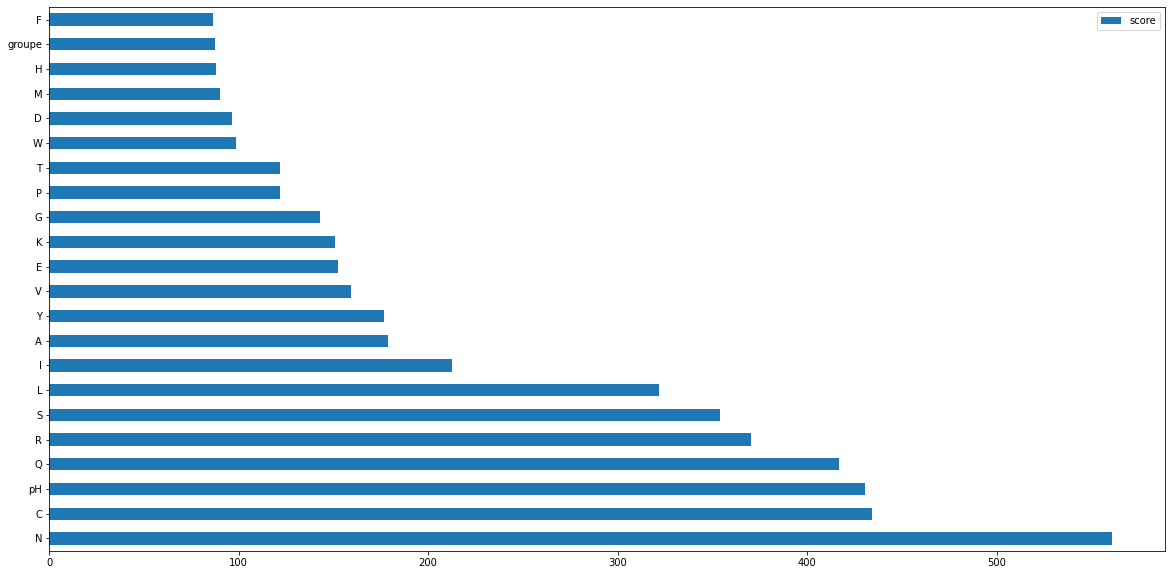

In [31]:
feature_importance = model.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(30, columns="score").plot(kind='barh', figsize = (20,10))

On retrouve bien le fait que le groupe à peu d'importance.

# Prédiction

On charge le fichier contenant les données de test avec les features correspondant au model que nous avons choisi, ainsi que le fichier 'sample_submission.csv' ou nous alons enregistrer la prédiction.

In [32]:
df_test = pd.read_csv("Data/test_1_for_modelisation.csv")
sub = pd.read_csv("Data/sample_submission.csv")

In [33]:
df_test

,seq_id,protein_sequence,pH,groupe,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,22,4,15,8,10,19,...,0,19,17,13,3,18,8,13,6,6
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,22,4,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,21793,22,4,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,22,5,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,22,4,15,7,11,19,...,0,19,17,13,3,18,8,13,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,21,4,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,21,4,15,7,10,19,...,0,19,17,13,3,18,8,13,6,6
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,21,4,15,7,10,19,...,0,20,17,13,3,18,8,13,6,6
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,21793,21,4,15,7,10,19,...,0,19,18,13,3,18,8,13,6,6


In [34]:
T = df_test.drop(['seq_id','protein_sequence'], axis=1).values

In [35]:
T = std.transform(T)

In [36]:
y_pred = model.predict(T)

In [37]:
y_pred

array([50.72032 , 50.716007, 50.80823 , ..., 50.640602, 50.656563,
       50.775784], dtype=float32)

In [38]:
sub

,seq_id,tm
0,31390,0
1,31391,1
2,31392,2
3,31393,3
4,31394,4
...,...,...
2408,33798,2408
2409,33799,2409
2410,33800,2410
2411,33801,2411


In [39]:
sub['tm'] = y_pred.T

In [40]:
sub

,seq_id,tm
0,31390,50.720322
1,31391,50.716007
2,31392,50.808231
3,31393,50.392700
4,31394,50.097198
...,...,...
2408,33798,49.946987
2409,33799,51.077000
2410,33800,50.640602
2411,33801,50.656563


In [41]:
sub['tm'].describe()

count    2413.000000
mean       51.060780
std         1.456298
min        48.384651
25%        50.322041
50%        50.689034
75%        51.031776
max        55.418442
Name: tm, dtype: float64

Les valeurs prédites sont concentrées autours de 50 degrés, mais il y a quand même un écart de 7 degré entre la valeur la plus basse et la valeur la plus élevée.

In [42]:
sub.to_csv("Submission/sample_submission.csv", index=False)